In [29]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os

In [30]:
class HPylorisDataset(Dataset):
    def __init__(self, data_folder, annotations, infected=-1, transform=None):
        """
        Inputs: 
            DATA_FOLDER: folder that contains all folders with the annotated images.
            ANNOTATIONS: csv file that labels the input images
            INFECTED: add infected (1), non-infected (-1) or all images (None) to dataset
            TRANSFORM: apply any kind of torchvision transforms to the images        
        """
        self.data_folder = data_folder
        self.annotations = annotations
        self.infected = infected
        self.transform = transform
        self.images = self.obtain_all_images(self.annotations, 
                                             self.data_folder,
                                             self.infected
                                             )
        
    def obtain_all_images(self, annotations, data_folder, infected):
        images = []        
        labels = pd.read_csv(annotations)
        for _, row in labels.iterrows():
            image_names = row['ID'].split('.')
            presence = row['Presence']
            if infected == None:
                image_path = os.path.join(data_folder+image_names[0], image_names[1]+'.png')
                if os.path.exists(image_path):
                    images.append(image_path)    
            elif presence == infected:
                image_path = os.path.join(data_folder+image_names[0], image_names[1]+'.png')
                if os.path.exists(image_path):
                    images.append(image_path)    
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        try:
            image = Image.open(img_name).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image
        except Exception as e:
            print(f"Error loading image '{img_name}': {str(e)}")
            return None

In [31]:
labels_path = '/fhome/mapsiv/QuironHelico/AnnotatedPatches/window_metadata.csv'
image_folders_path = '/fhome/mapsiv/QuironHelico/AnnotatedPatches/'

# Define data augmentation transforms
myTransforms = transforms.Compose([transforms.RandomHorizontalFlip(),  
                                   transforms.RandomRotation(10),     
                                   transforms.ToTensor(),       
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

nonInfectedDataset = HPylorisDataset(image_folders_path, labels_path, infected=-1, transform=myTransforms)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15 

train_size = int(train_ratio * len(nonInfectedDataset))
val_size = int(val_ratio * len(nonInfectedDataset))
test_size = len(nonInfectedDataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(nonInfectedDataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

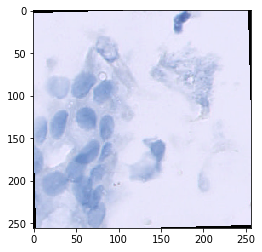

In [44]:
transformed_image = nonInfectedDataset[13]

normalized_image = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                        std=[1/0.229, 1/0.224, 1/0.225])(transformed_image)

pil_image = transforms.ToPILImage()(normalized_image)

plt.imshow(pil_image)
plt.show()